In [51]:
# Fix times in plot axis
# Comment
# Further Analysis
# Non Linear


# Coop Study Case Forecasting 

 

## AR Modeling

In [52]:
# Libraries 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pylab as pylab
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error as mse 
from sklearn.neural_network import MLPRegressor

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (22, 14),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)

#### Import functions from ./Functions_Forecasting AR file in this same folder, look for comments on the functions in that notebook



In [53]:
from ipynb.fs.defs.Functions_Forecasting import * 


### importing data

In [54]:
data = pd.read_csv("./4months_v2/rl_4months.csv")

In [55]:
data.shape

(3221229, 40)

Subsetting of the data with the convenient columns

In [56]:
# Generate unique name 
data['Unique_Item_Name'] = data['ItemCategoryName'] + '_' + data['ItemSegmentName']

In [57]:
data_subset = data[['DayDate','hourOfDay', 'ItemID', 'quantity']]



### Deletion of returns and false duplicates of Negative and 0 Quantities

In [58]:
data_subset = data_subset[data_subset.quantity>0]

In [59]:
data_subset['timestamp'] = data_subset['DayDate'].astype(str) + ' '+  data_subset['hourOfDay'].astype(str)


#### Generation of Support Timestamp Vectors

This is to filled with 0 sales the timestamps with no sales of an specific product. But we want that day or hour to figure

In [60]:
# Days Vector
timestamp_agg_days = data_subset['DayDate'].unique()
timestamp_agg_days.sort()


In [61]:
# Day Hour Vector
timestamp_agg_hours = [None] * len(timestamp_agg_days)*16

count = 0
for i in range(len(timestamp_agg_days)):
    
    for j in range(16):
        
        timestamp_agg_hours[count] = timestamp_agg_days[i] + ' ' + str(7 + j)
        count+=1


### Aggregating Datasets

We group by hour/day and product_id

In [62]:
# Aggregation of items with HOURLY criterion and counting ocurrences

df_agg_hours = data_subset.groupby(['timestamp', 'ItemID']).sum()
df_agg_hours.reset_index(inplace=True)
df_agg_hours.drop(columns=['hourOfDay'], inplace=True)

# Aggregation of items with DAYLY criterion and counting ocurrences

df_agg_days = data_subset.groupby(['DayDate', 'ItemID']).sum()
df_agg_days.reset_index(inplace=True)
df_agg_days.drop(columns='hourOfDay', inplace=True)

### Visualisation of ItemID = 7

In [63]:
ItemID = 7
name_item = data[data["ItemID"]==ItemID]['Unique_Item_Name'].iloc[0]
name_item

'LÖSVIKTSGODIS_STANDARD'

In [64]:
hourly_purchase_7 = get_hourly_purchases(df_agg_hours,timestamp_agg_hours, ItemID)

In [65]:
daily_purchase_7 = get_daily_purchases(df_agg_days, timestamp_agg_days, ItemID)

In [66]:
df = hourly_purchase_7
df.reset_index(inplace = True)
df

,timestamp,quantity
0,2020-02-01 7,0.000
1,2020-02-01 8,0.568
2,2020-02-01 9,3.874
3,2020-02-01 10,4.020
4,2020-02-01 11,7.596
...,...,...
1931,2020-05-31 18,0.000
1932,2020-05-31 19,1.066
1933,2020-05-31 20,0.062
1934,2020-05-31 21,0.000


We could work out an interactive zoom-enabled visualization


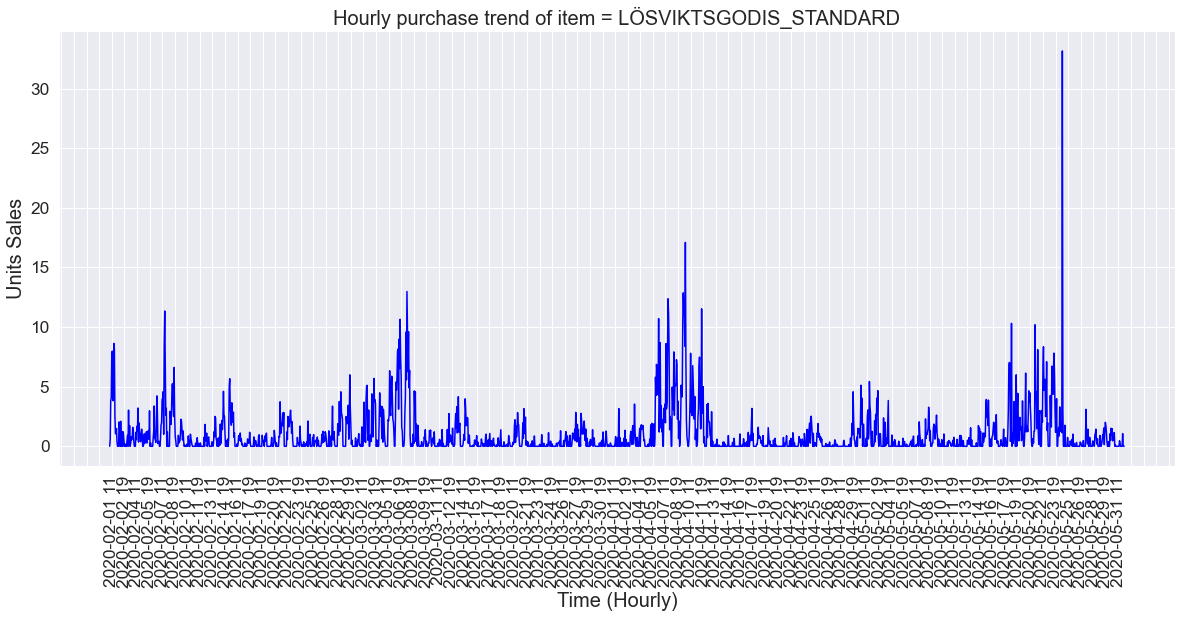

In [77]:
plot_trend_item(name_item, hourly_purchase_7.set_index('timestamp'), 0, interval=24)

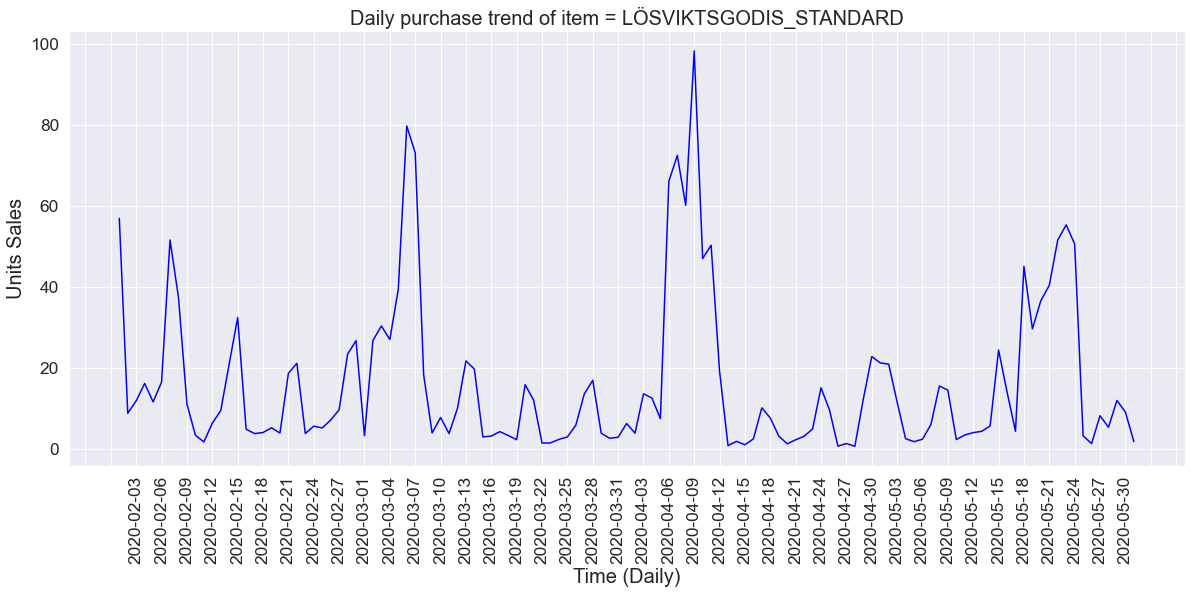

In [69]:
plot_trend_item(name_item, daily_purchase_7, 1, interval=3)

### Visualisation of ItemID = 5

In [78]:
ItemID = 5
name_item = data[data["ItemID"]==ItemID]['Unique_Item_Name'].iloc[0]

In [79]:
hourly_purchase_5 = get_hourly_purchases(df_agg_hours,timestamp_agg_hours, ItemID)

In [80]:
daily_purchase_5 = get_daily_purchases(df_agg_days, timestamp_agg_days, ItemID)

### Visualisation of ItemID = 322

In [83]:
ItemID = 322
name_item = data[data["ItemID"]==ItemID]['Unique_Item_Name'].iloc[0]

In [84]:
hourly_purchase_322 = get_hourly_purchases(df_agg_hours,timestamp_agg_hours, ItemID)

In [85]:
daily_purchase_322 = get_daily_purchases(df_agg_days,timestamp_agg_days, ItemID)

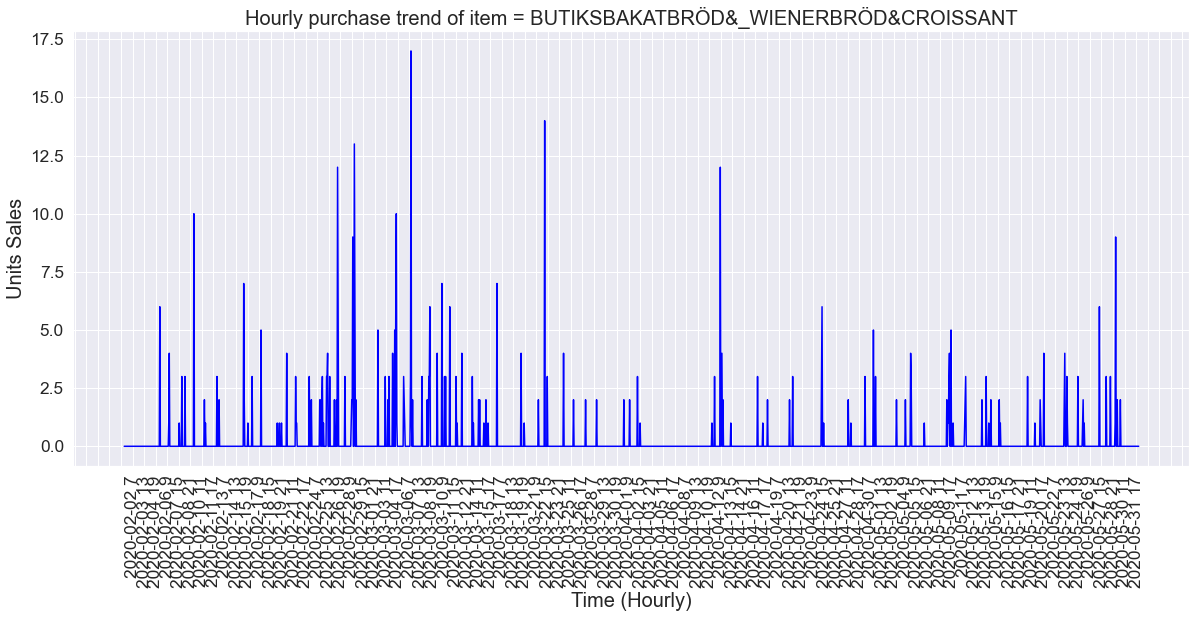

In [86]:
plot_trend_item(name_item, hourly_purchase_322, 0, interval=22)

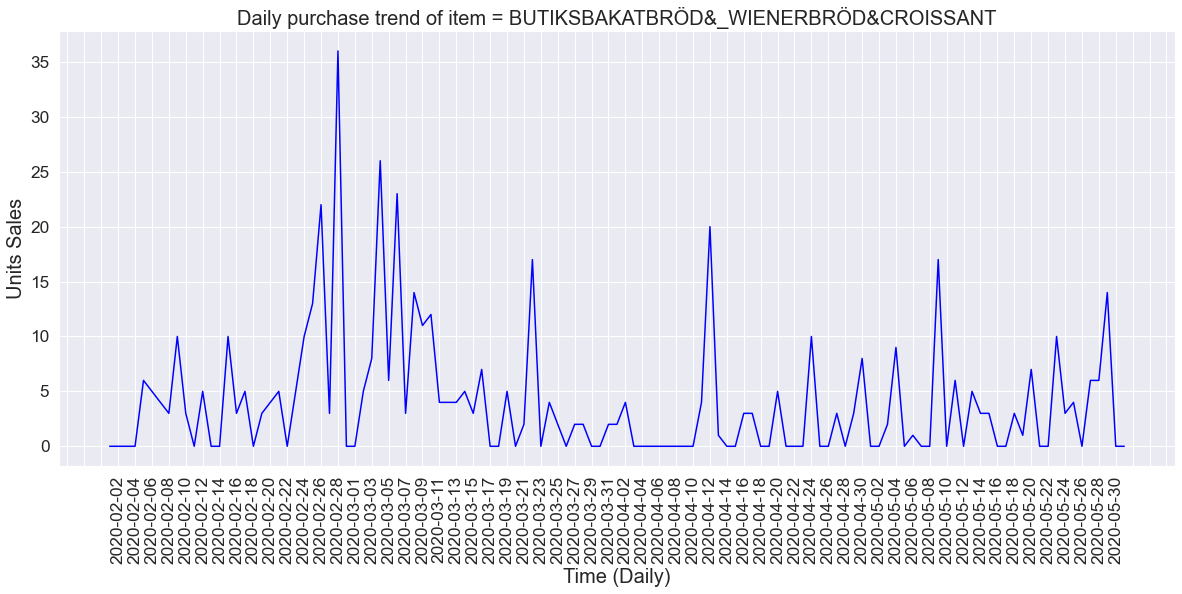

In [87]:
plot_trend_item(name_item, daily_purchase_322, 1, interval=2)


### Visualisation of ItemID = 303199

In [88]:
ItemID = 303199
name_item = data[data["ItemID"]==ItemID]['Unique_Item_Name'].iloc[0]

In [89]:
hourly_purchase_303199 = get_hourly_purchases(df_agg_hours,timestamp_agg_hours, ItemID)

In [90]:
daily_purchase_303199 = get_daily_purchases(df_agg_days, timestamp_agg_days, ItemID)

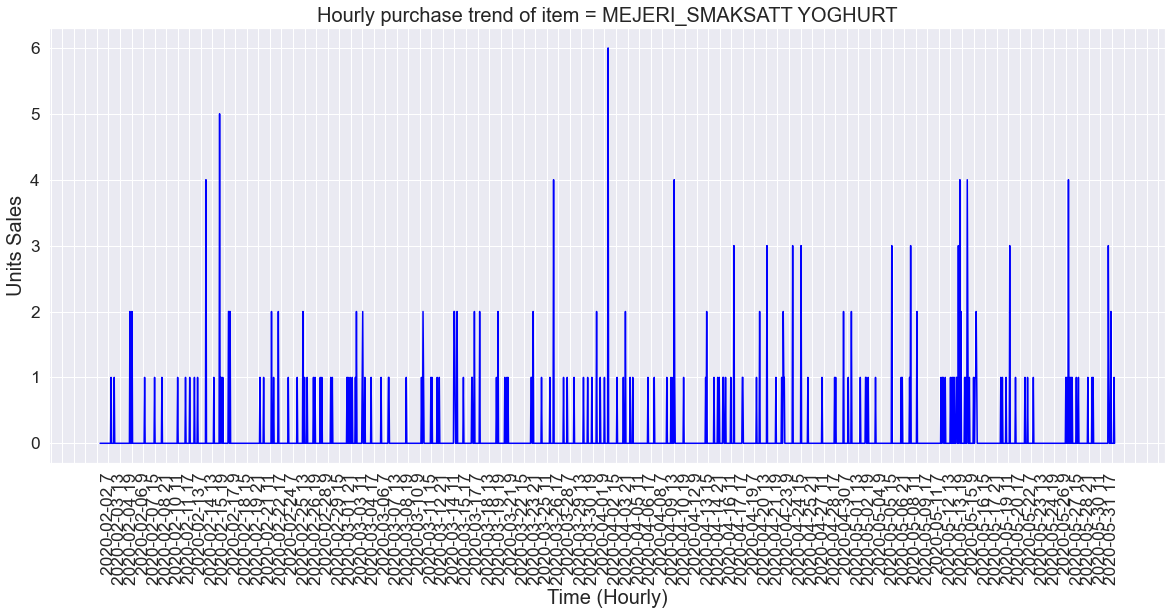

In [91]:
plot_trend_item(name_item, hourly_purchase_303199, 0, interval=22)

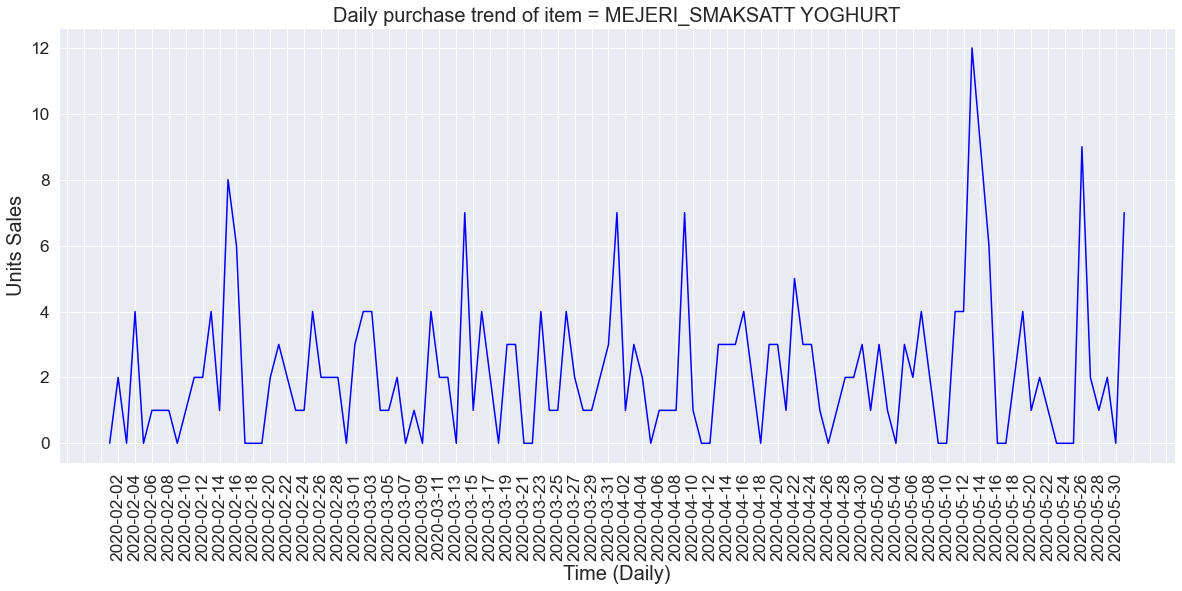

In [92]:
plot_trend_item(name_item, daily_purchase_303199, 1, interval=2)


### Visualisation of ItemID = 300082

In [93]:
ItemID = 300082
name_item = data[data["ItemID"]==ItemID]['Unique_Item_Name'].iloc[0]

In [94]:
hourly_purchase_300082 = get_hourly_purchases(df_agg_hours,timestamp_agg_hours, ItemID)

In [95]:
daily_purchase_300082 = get_daily_purchases(df_agg_days,timestamp_agg_days, ItemID)

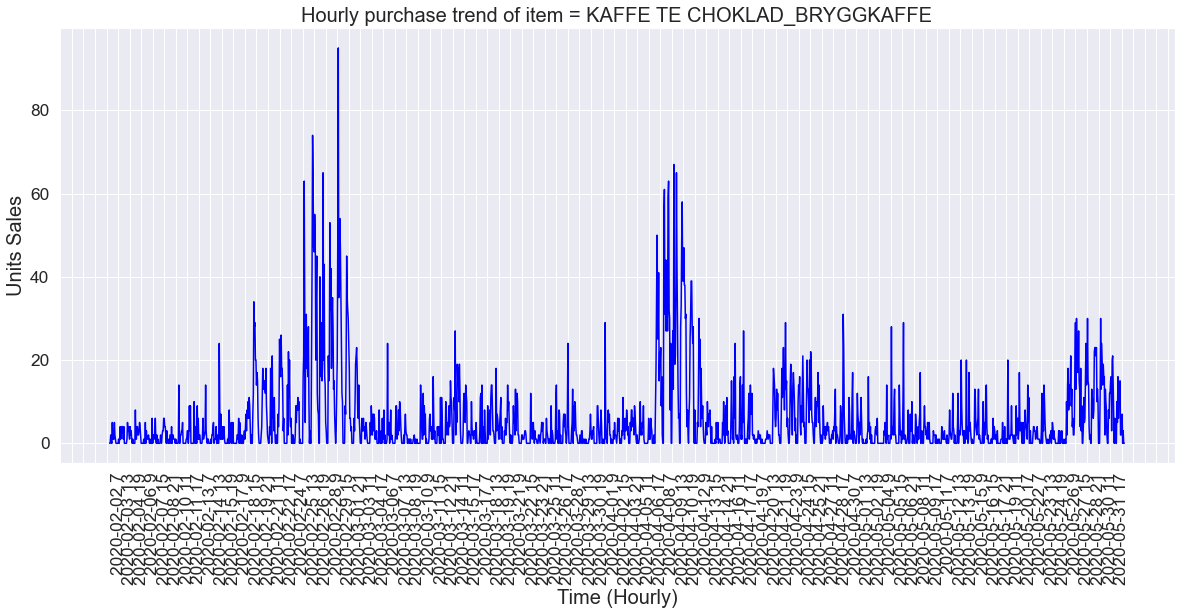

In [96]:
plot_trend_item(name_item, hourly_purchase_300082, 0, interval=22)

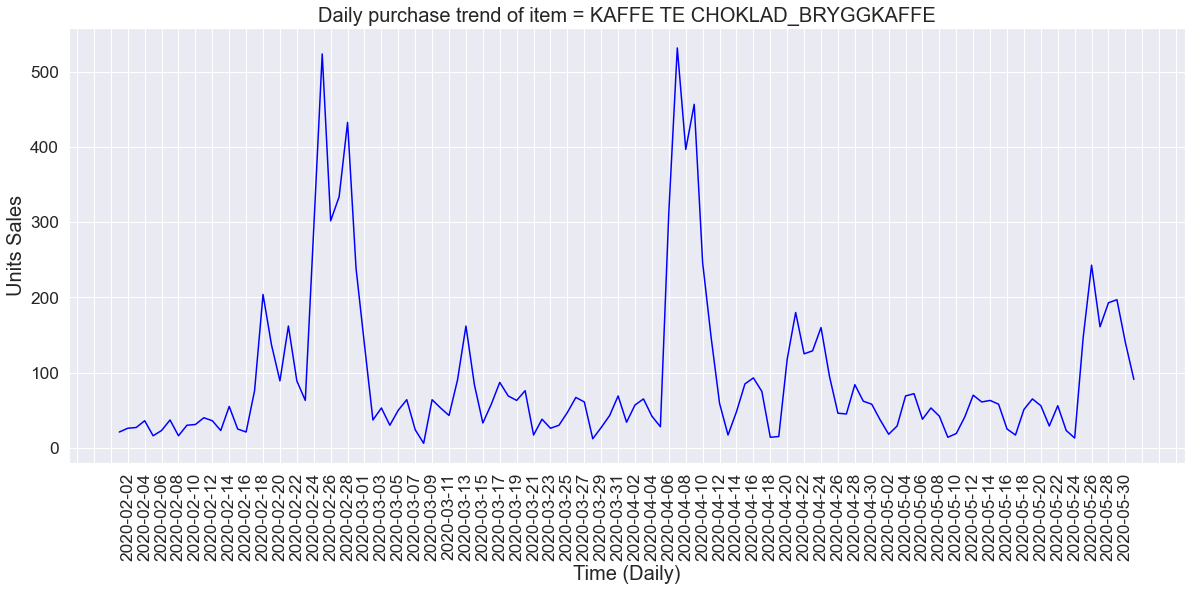

In [97]:
plot_trend_item(name_item, daily_purchase_300082, 1, interval=2)


## AR Modeling

### Product 7 Modeling

In [148]:
# Training size to fit the Model Parameters
train_size = 50
train = daily_purchase_7.quantity.values[:train_size]
test = daily_purchase_7.quantity.values[train_size:]
print("train data samples: {0}, test data samples {1}".format(len(train), len(test)))


train data samples: 50, test data samples 71


Order of the AR Model


In [149]:
p=2

In [150]:
train = np.expand_dims(train, 1)

coef = fit_ar(train, p)

ItemID = 7
name_item = data[data["ItemID"]==ItemID]['Unique_Item_Name'].iloc[0]
name_item

'LÖSVIKTSGODIS_STANDARD'

### Let's Check ACF plot

Blue area depicts the 95% confidence interval and is in indicator for the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.



In [140]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

### Augmented Dickey–Fuller test (ADF)-based check 

In [142]:
check_stationarity(daily_purchase_7.quantity)

ADF Statistic: -5.054178
p-value: 0.000017
Critical Values:
	1%: -3.486
	5%: -2.886
	10%: -2.580
Stationary


<Figure size 1296x144 with 0 Axes>

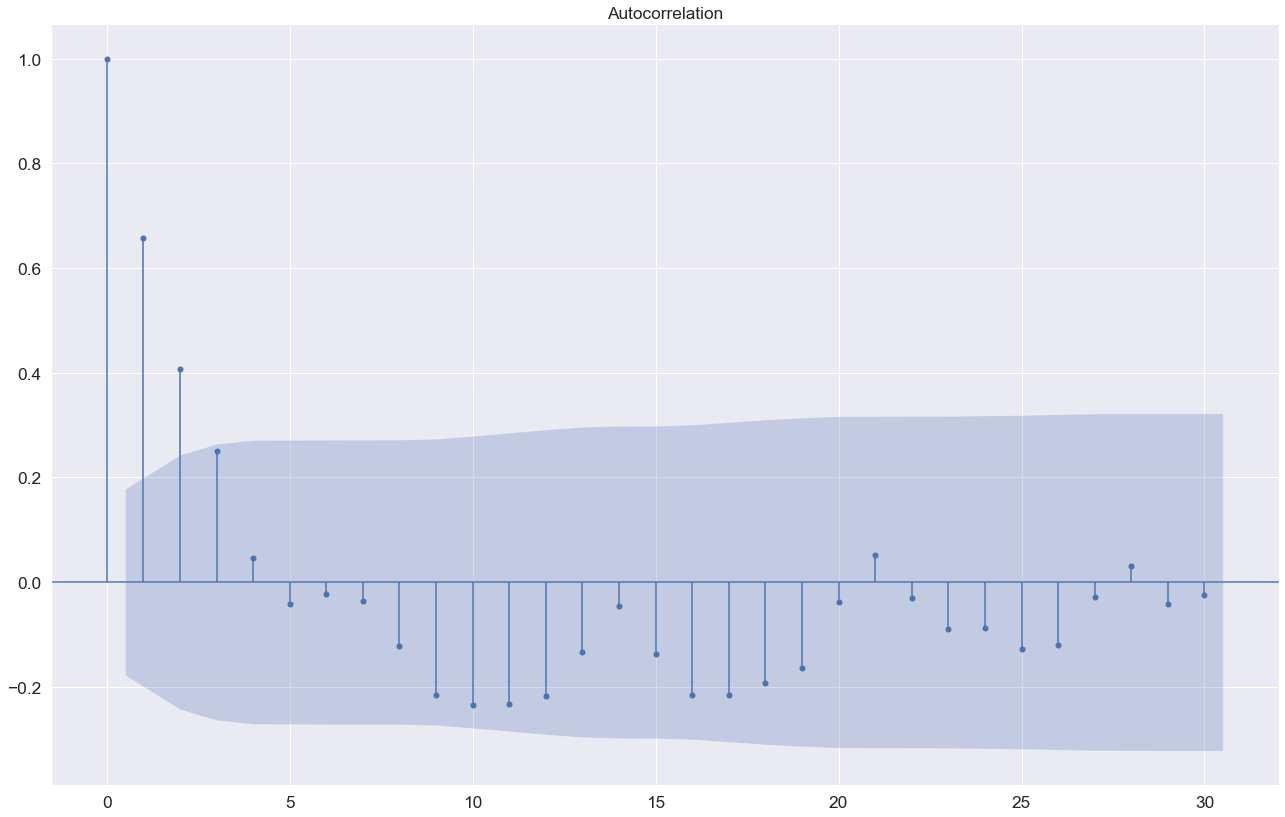

In [158]:
import statsmodels.api as sm

plt.figure(figsize=(18,2))    
sm.graphics.tsa.plot_acf(daily_purchase_7.quantity.values.squeeze(), lags=30)

plt.show()

Observation: Weekly pattern? observable. Constant decay

### PACF excludes the previous indirect effects from the lags in the correlation

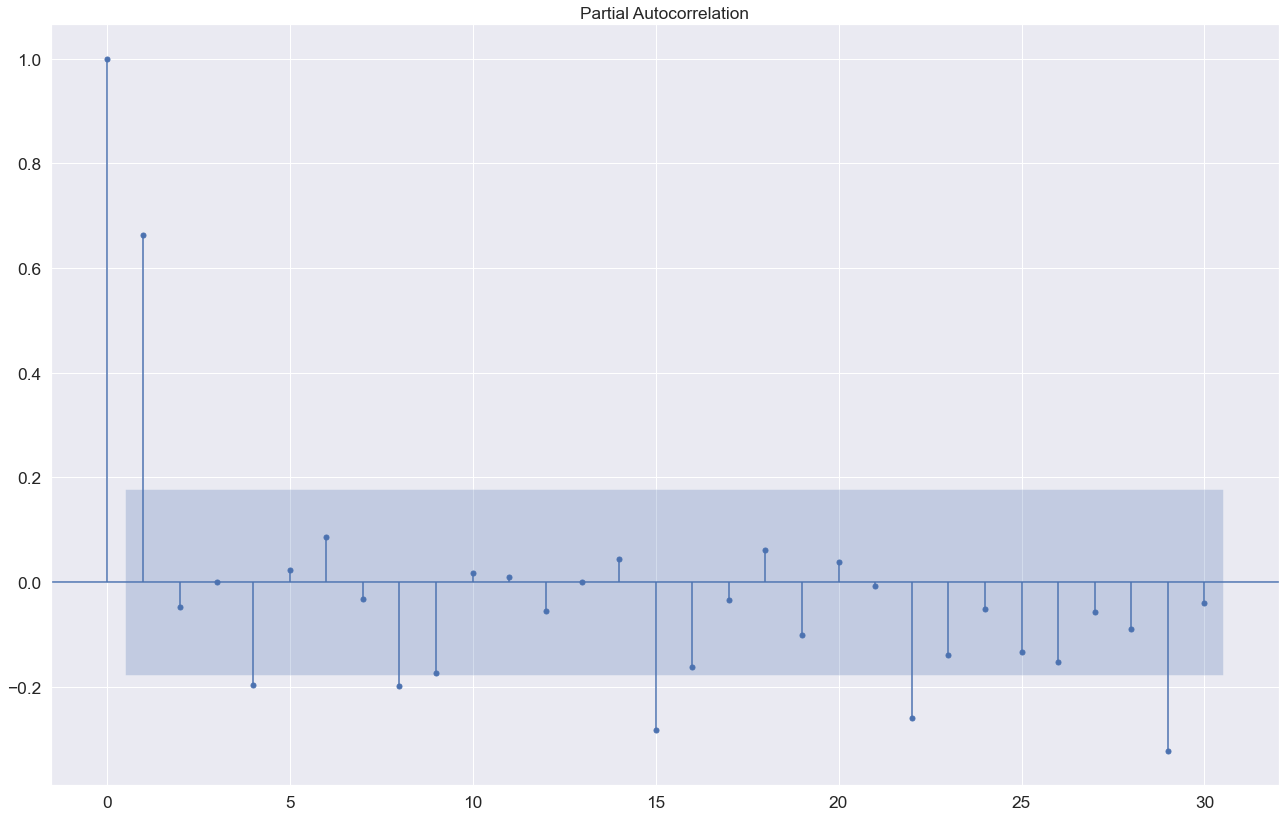

In [132]:
sm.graphics.tsa.plot_pacf(daily_purchase_7.quantity.values.squeeze(), lags=30)
plt.show()

### Prediction for all 


In [151]:
predictions_all = predict_ar_1step(coef, daily_purchase_7.quantity.values)[:-1]
y_true = daily_purchase_7[p:]


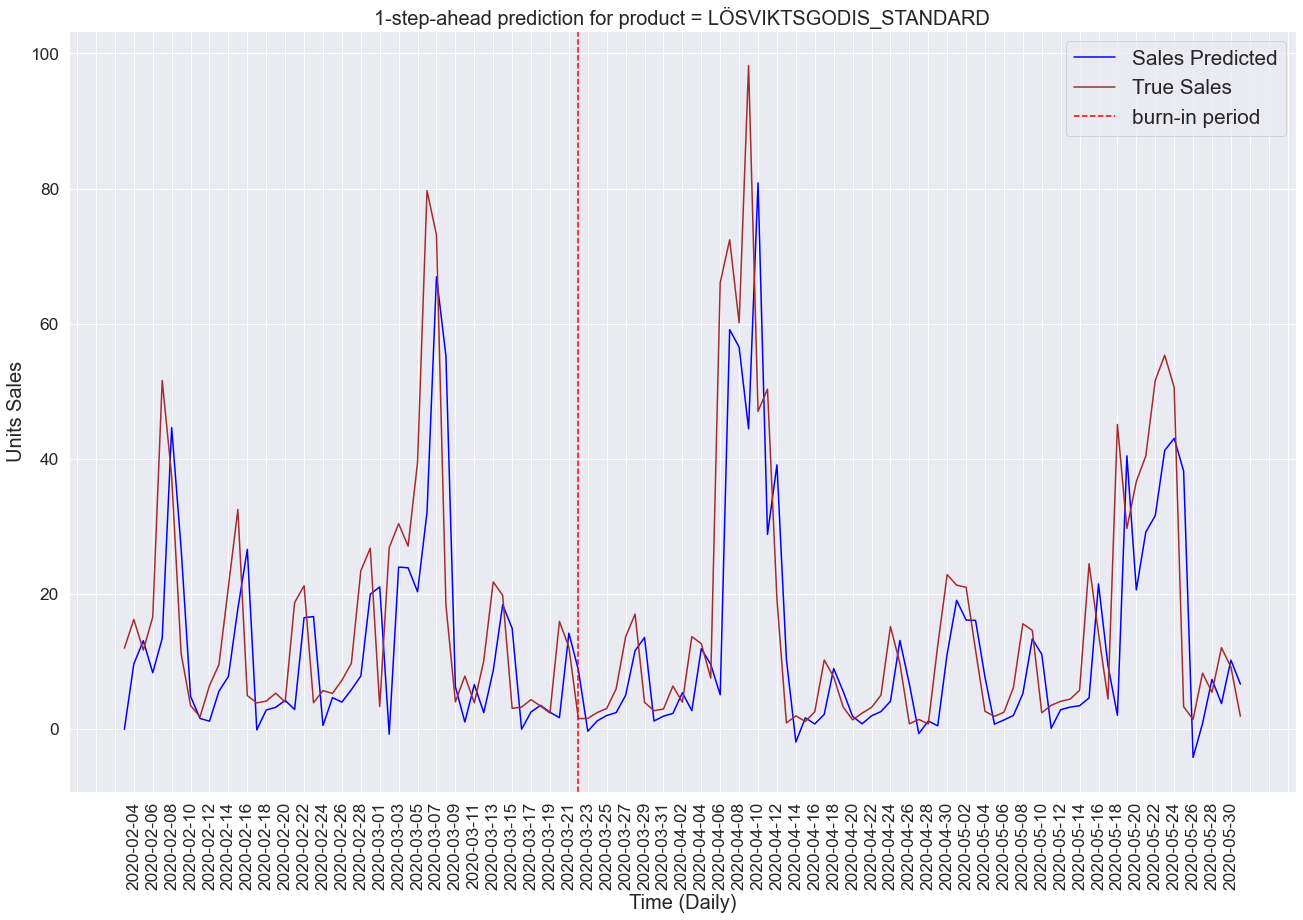

In [152]:
plot_predictions_1step(predictions_all, y_true, name_item, train_size-p)

Text(0.5, 1.0, 'Prediction Residuals of item = LÖSVIKTSGODIS_STANDARD')

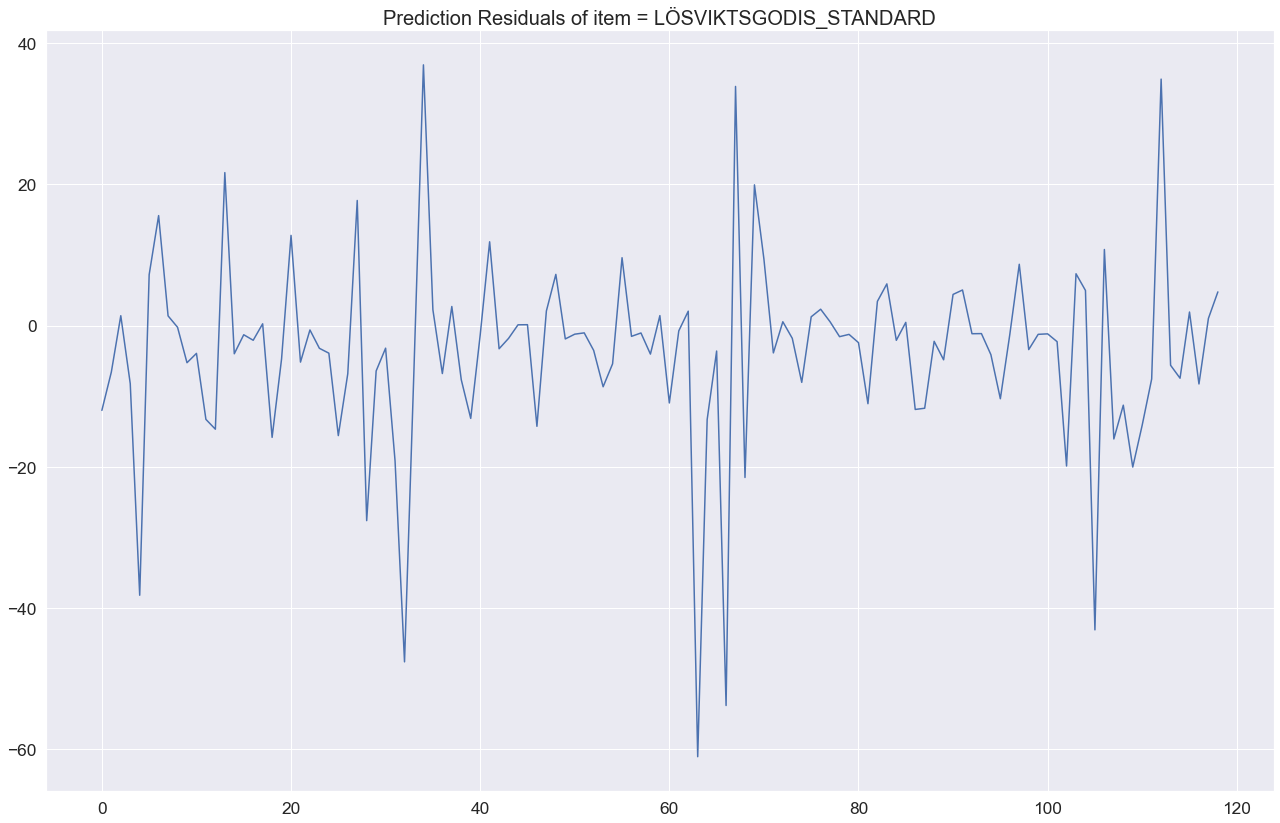

In [153]:
plt.plot(predictions_all - y_true.quantity.values)
plt.title("Prediction Residuals of item = " + name_item, size=20)    


#### Hourly Prediction product 7

In [159]:
# Training size to fit the Model Parameters
train_size = 48
train = hourly_purchase_7.quantity.values[:train_size]
test = hourly_purchase_7.quantity.values[train_size:]
print("train data samples: {0}, test data samples {1}".format(len(train), len(test)))


train data samples: 48, test data samples 1888


In [160]:
check_stationarity(hourly_purchase_7.quantity)

ADF Statistic: -4.754543
p-value: 0.000066
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
Stationary


<Figure size 1296x144 with 0 Axes>

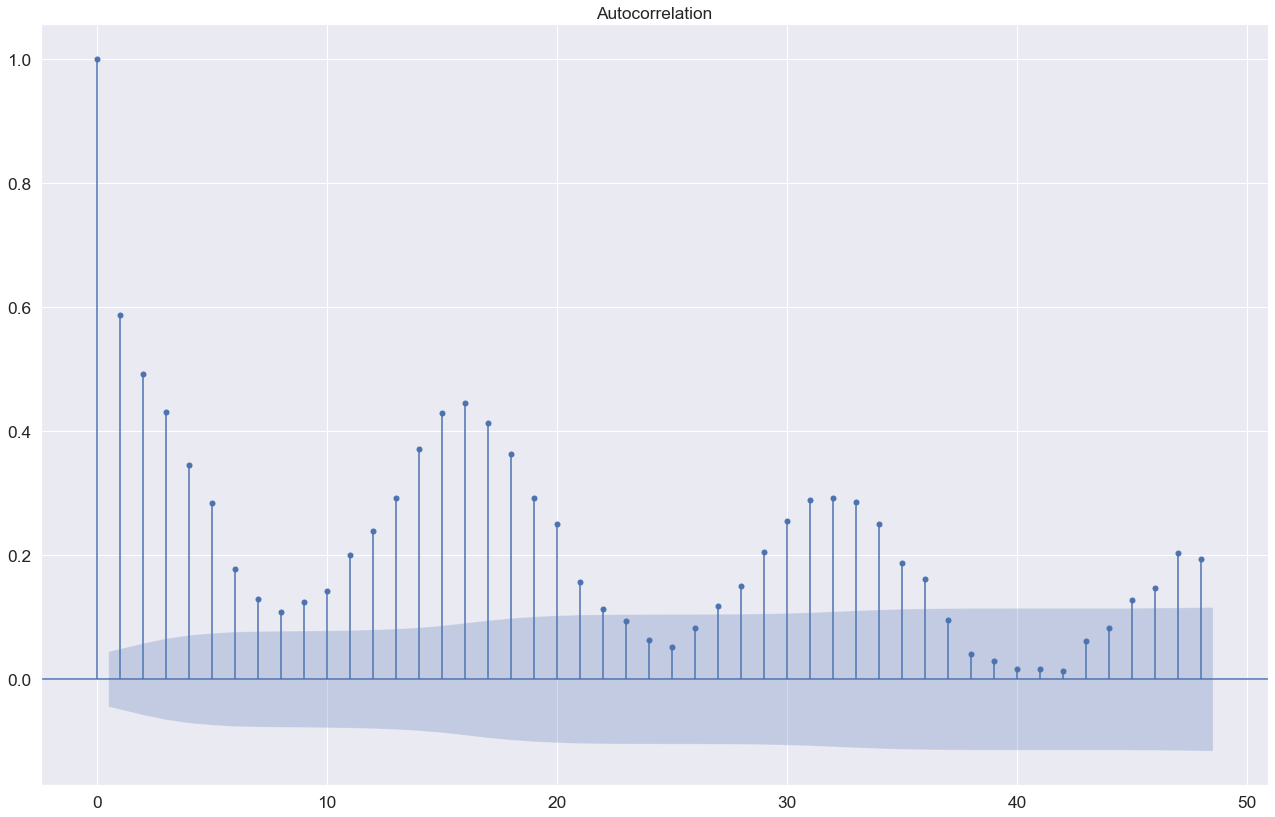

In [165]:
import statsmodels.api as sm

plt.figure(figsize=(18,2))    
sm.graphics.tsa.plot_acf(hourly_purchase_7.quantity.values.squeeze(), lags=48)

plt.show()

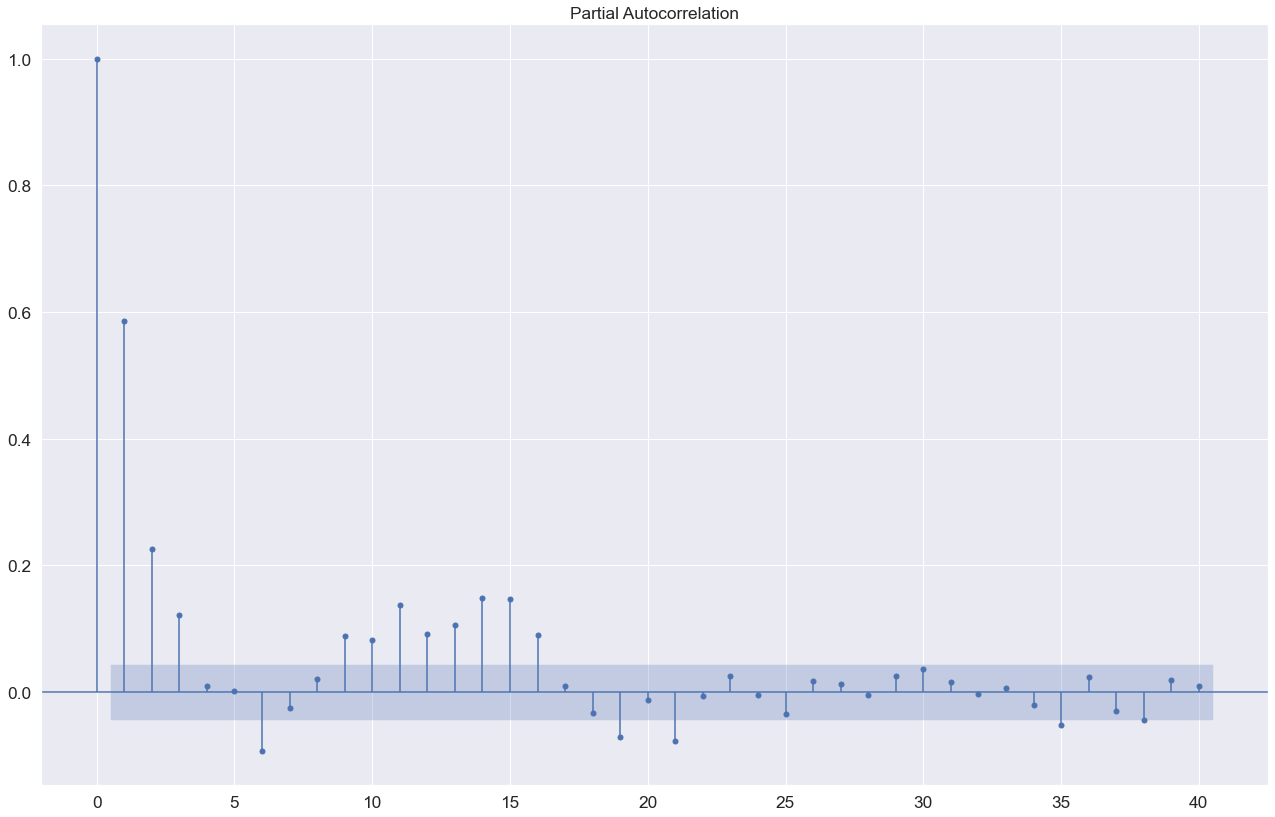

In [167]:
sm.graphics.tsa.plot_pacf(hourly_purchase_7.quantity.values.squeeze(), lags=40)
plt.show()

Order of the AR Model


In [168]:
p=16

In [169]:
train = np.expand_dims(train, 1)

coef = fit_ar(train, p)

ItemID = 7
name_item = data[data["ItemID"]==ItemID]['Unique_Item_Name'].iloc[0]
name_item

'LÖSVIKTSGODIS_STANDARD'

### Prediction for all 


In [174]:
hourly_purchase_7.set_index('timestamp', inplace=True)

In [176]:
predictions_all = predict_ar_1step(coef, hourly_purchase_7.quantity.values)[:-1]
y_true = hourly_purchase_7[p:]


In [123]:
(predictions_all - y_true.quantity.values).mean()

-1.5110575061579286

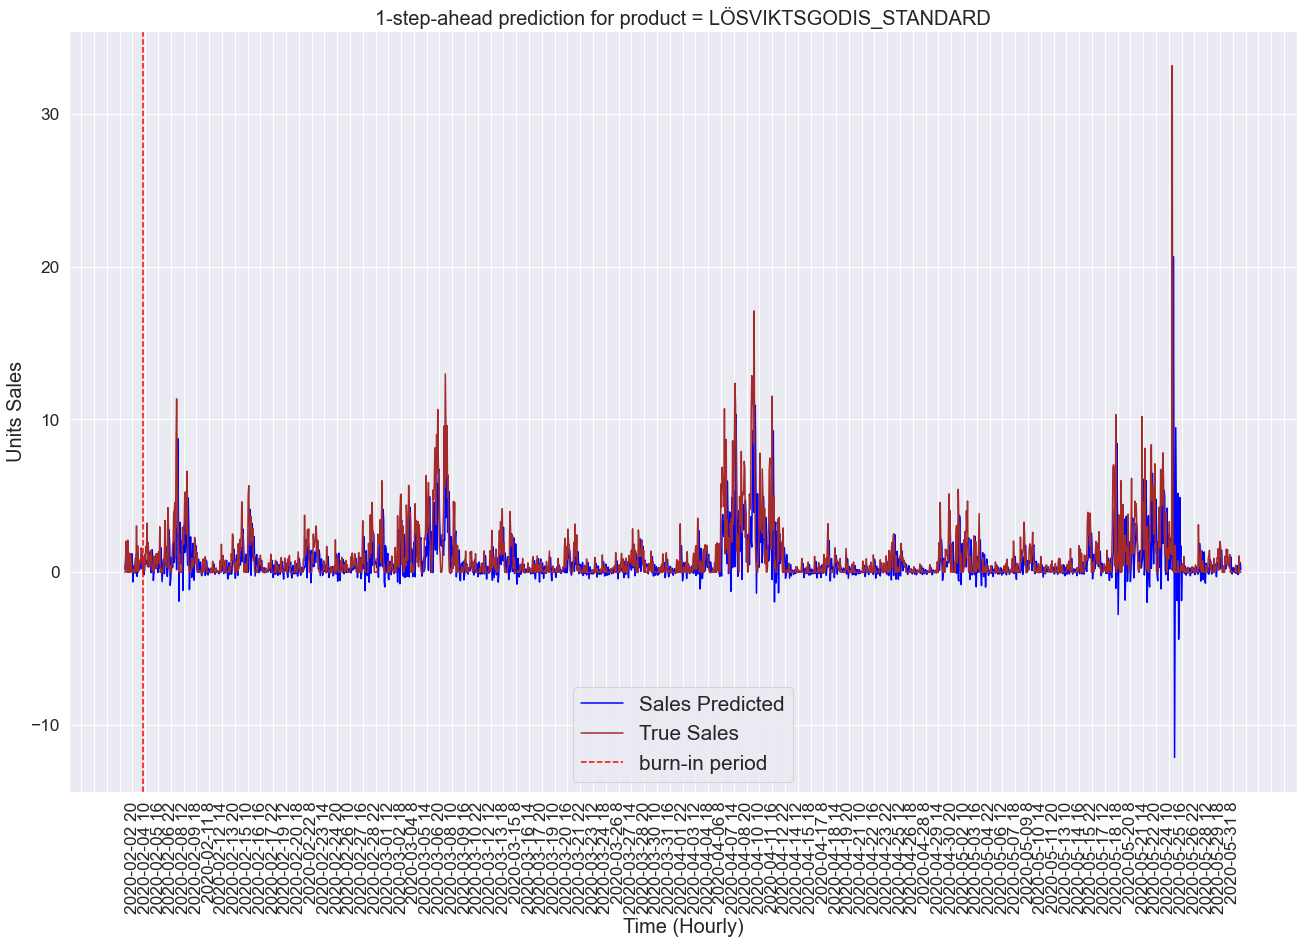

In [177]:
plot_predictions_1step(predictions_all, y_true, name_item, train_size-p, daily=0, interval = 22)

## (Optional) Model validation and order selection in prediction of 7


MSE: we are assuming Residuals normaly distributed and equal variance. Also it assumes it comes from - LogLikelihood (Maximum Likelihood Estimation) of the derivation

$$p(y\mid x,\theta) = \mathcal{N}(y\mid f(x,\theta), \beta^{-1})$$

$$p(y\mid X,\theta,\beta) = \prod_{n=1}^N p(y_n\mid x_n,\theta,\beta)$$


In [178]:

train_error = np.zeros(40)
test_error = np.zeros(40)

for i in range(40):
    p = i + 2
    coef = fit_ar(train, p)
    predictions_train = predict_ar_1step(coef, train.flatten())
    train_error[i] = mse(train.flatten()[(p):], predictions_train[:-1])
    predictions_test = predict_ar_1step(coef, test.flatten())
    test_error[i] = mse(test.flatten()[(p):], predictions_test[:-1])



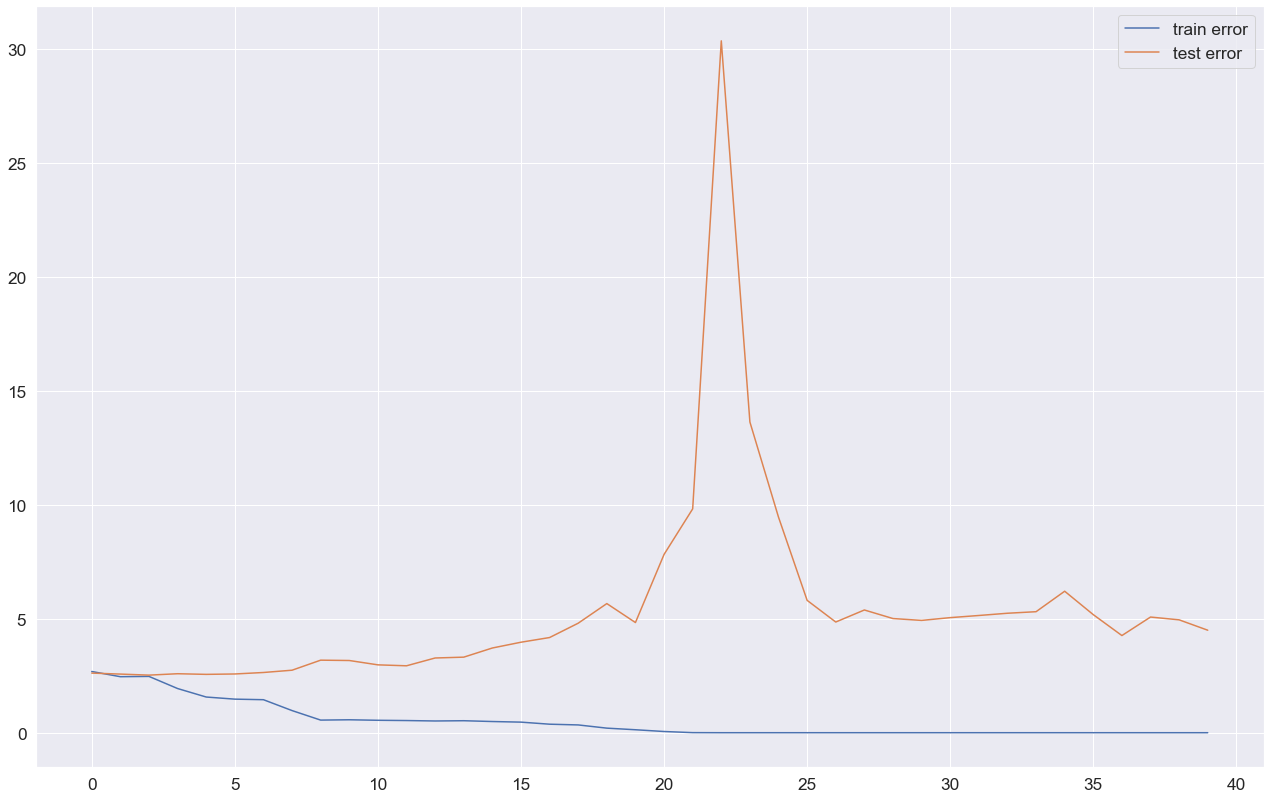

In [179]:
plt.plot(train_error, label = "train error")
plt.plot(test_error, label = "test error")
plt.legend()
plt.show()

### Product 300082 Modeling

In [215]:
ItemID = 300082
name_item = data[data["ItemID"]==ItemID]['Unique_Item_Name'].iloc[0]

ADF Statistic: -3.699250
p-value: 0.004124
Critical Values:
	1%: -3.490
	5%: -2.887
	10%: -2.581
Stationary


<Figure size 1296x144 with 0 Axes>

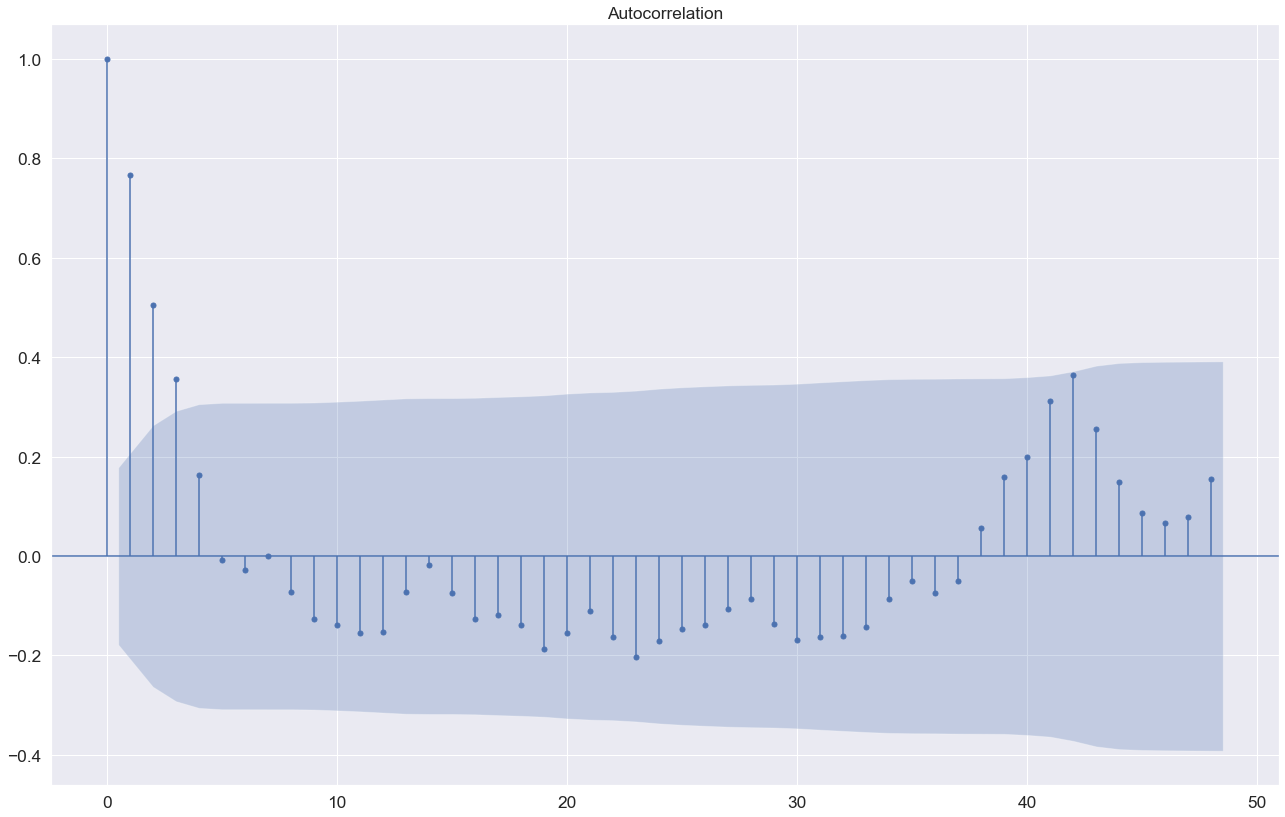

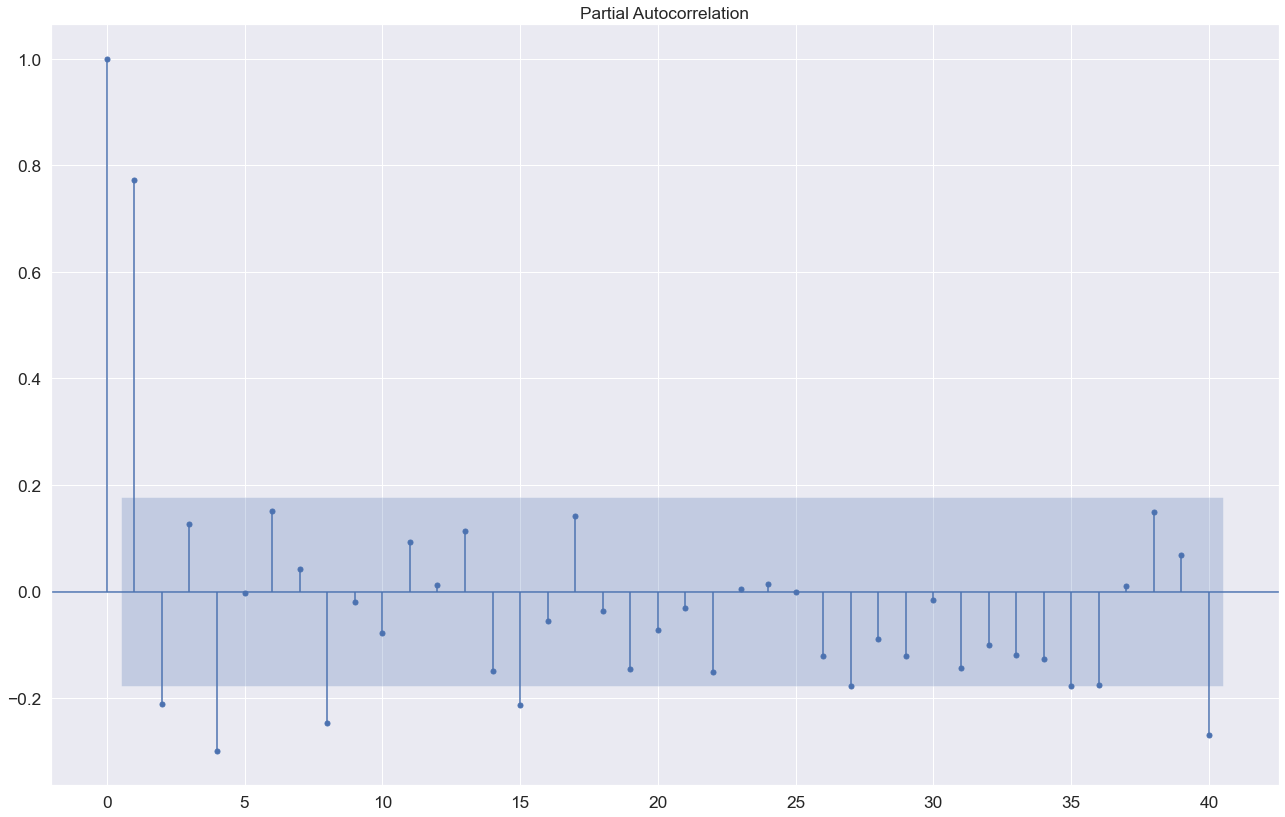

In [217]:
check_stationarity(daily_purchase_300082.quantity)

import statsmodels.api as sm

plt.figure(figsize=(18,2))    
sm.graphics.tsa.plot_acf(daily_purchase_300082.quantity.values.squeeze(), lags=48)

plt.show()

sm.graphics.tsa.plot_pacf(daily_purchase_300082.quantity.values.squeeze(), lags=40)
plt.show()

In [232]:
# Training size to fit the Model Parameters
train_size = 50
train = daily_purchase_300082.quantity.values[:train_size]
test = daily_purchase_300082.quantity.values[train_size:]
print("train data samples: {0}, test data samples {1}".format(len(train), len(test)))


train data samples: 50, test data samples 71


Order of the AR Model


In [233]:
p=15

In [234]:
train = np.expand_dims(train, 1)

coef = fit_ar(train, p)


### Prediction for ALL time


In [235]:
predictions_all = predict_ar_1step(coef, daily_purchase_300082.quantity.values)[:-1]
y_true = daily_purchase_300082[p:]

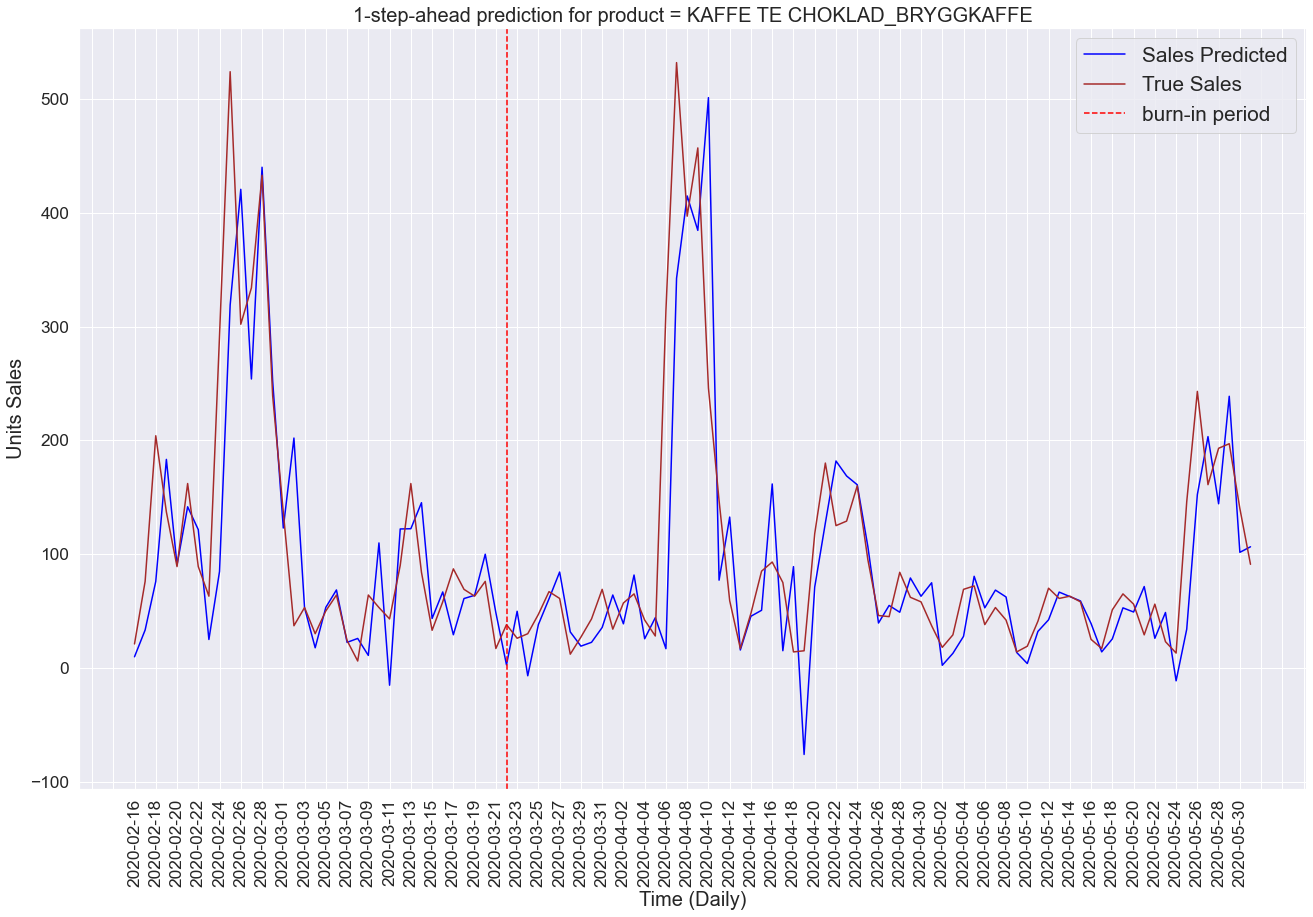

In [236]:
plot_predictions_1step(predictions_all, y_true, name_item, train_size-p)


## Model validation and order selection in prediction of 300082


In [237]:

train_error = np.zeros(40)
test_error = np.zeros(40)

for i in range(40):
    p = i + 2
    coef = fit_ar(train, p)
    predictions_train = predict_ar_1step(coef, train.flatten())
    train_error[i] = mse(train.flatten()[(p):], predictions_train[:-1])
    predictions_test = predict_ar_1step(coef, test.flatten())
    test_error[i] = mse(test.flatten()[(p):], predictions_test[:-1])



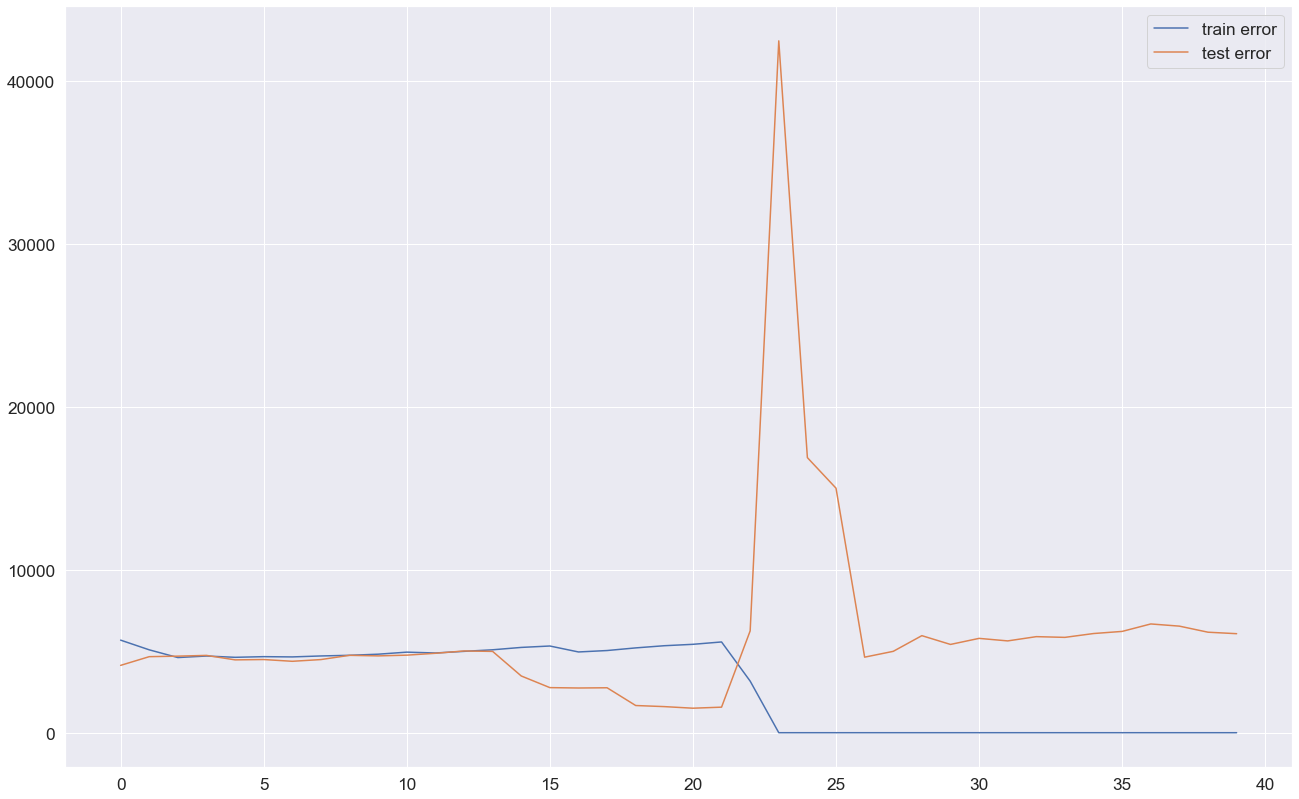

In [238]:
plt.plot(train_error, label = "train error")
plt.plot(test_error, label = "test error")
plt.legend()
plt.show()